# UIUC Grid Demand: Solar Power + Solar Elevation Angle

This notebook uses an Echo State Network(ESN) (from pyESN) to predict the solar generation at the University of Illinois.
Rather than one input, there are two inputs: Solar Power and Solar Elevation Angle. 
The following items are included:

1. An initial demonstration of the ESN with a 72-hour prediction.
2. Grid optimization over spectral radius and noise
3. Grid optimization over reservoir size and sparsity
4. Demonstrate the effect of training length on accuracy.
5. A final demonstration of the ESN with optimized hyper-parameters.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, "/home/dotson/research/cairo")


# custom libraries
from tools import MSE, esn_prediction, param_string, optimal_values
from optimizers import grid_optimizer
from sunrise import generate_elevation_series
from pyESN.pyESN import ESN

In [2]:
# import demand data
dataframe = pd.read_csv("../data/solarfarm_data.csv", usecols=['time','power_data'])
solarpower = np.array(dataframe.power_data).astype('float64')

# normalize
norm = np.linalg.norm(solarpower)
solarpower_norm = solarpower/norm

In [3]:
time_range = pd.date_range(start='1/1/2016', end='1/1/2019', freq='h')[:len(solarpower)]
elevation = generate_elevation_series(time_range, timestamps=True)
norm_a = np.linalg.norm(elevation)
angles_norm = elevation/norm_a
print(f"Norm of elevation angles: {norm_a}")
print(f"Norm of demand: {norm}")

Norm of elevation angles: 5858.1583307164465
Norm of demand: 260004.41436762564


## Format the Input Data

In [4]:
X_in = np.concatenate([[solarpower_norm, angles_norm]], axis=1)
    
print(f"Shape of X_in is {X_in.shape}")

Shape of X_in is (2, 26304)


In [5]:
params = {'n_reservoir':1000, 
          'sparsity':0.1, 
          'rand_seed':85, 
          'rho':1.5, 
          'noise':0.0001, 
          'future':72, 
          'window':None, 
          'trainlen':8000}

In [6]:
futureTotal = params['future']
time_range = np.array(dataframe.time)
hour_range = np.arange(0, len(time_range), 1)

## 1. Initial Demonstration


In [7]:
tic = time.perf_counter()

init_pred = esn_prediction(X_in.T, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 13.62 seconds
This simulation took 0.23 minutes


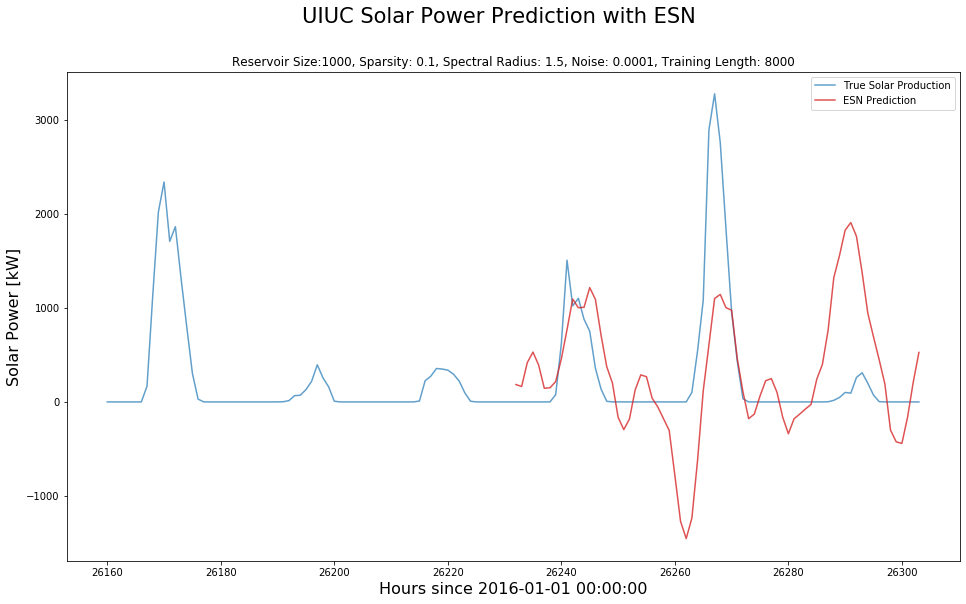

In [8]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Solar Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("Solar Power [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*solarpower_norm[-2*futureTotal:],'b',label="True Solar Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*init_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 2. Grid Optimization Over Spectral Radius and Noise

Optimizing over ['rho', 'noise']:
rho = 0.5, noise = 0.0001, MSE=0.00583874095715199
rho = 0.5, noise = 0.0003, MSE=0.005586840356875573
rho = 0.5, noise = 0.0007, MSE=0.005745673551676376
rho = 0.5, noise = 0.001, MSE=0.005692765462248509
rho = 0.5, noise = 0.003, MSE=0.004485691720742224
rho = 0.5, noise = 0.005, MSE=0.004438814206599702
rho = 0.5, noise = 0.007, MSE=0.0050591814649353535
rho = 0.5, noise = 0.01, MSE=0.005873730516640194
rho = 0.7, noise = 0.0001, MSE=0.00481120804902138
rho = 0.7, noise = 0.0003, MSE=0.004789995205246274
rho = 0.7, noise = 0.0007, MSE=0.005154655624467061
rho = 0.7, noise = 0.001, MSE=0.005290250716140799
rho = 0.7, noise = 0.003, MSE=0.004965934006434599
rho = 0.7, noise = 0.005, MSE=0.004592259024614458
rho = 0.7, noise = 0.007, MSE=0.0049177893552698965
rho = 0.7, noise = 0.01, MSE=0.005717417250714136
rho = 0.9, noise = 0.0001, MSE=0.003781597098456262
rho = 0.9, noise = 0.0003, MSE=0.004700410209617567
rho = 0.9, noise = 0.0007, MSE=0.004692694

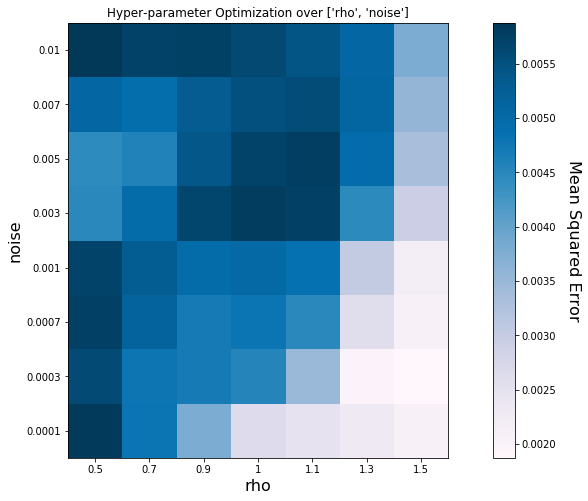

In [9]:
tic = time.perf_counter()
radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]

radiusxnoise_loss = grid_optimizer(X_in.T,
                      params,
                      args=['rho', 'noise'],
                      xset=radius_set,
                      yset=noise_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [10]:
opt_radius, opt_noise = optimal_values(radiusxnoise_loss, radius_set, noise_set)
params['rho'] = opt_radius
params['noise'] = opt_noise
print(f'The optimal set is:\nspectrum radius = {opt_radius} \nnoise = {opt_noise}')

The optimal set is:
spectrum radius = 1.5 
noise = 0.0003


### 3. Grid Optimization Over Reservoir Size and Sparsity

The algorithm is unstable when ``n_reservoir == trainlen``.

Optimizing over ['n_reservoir', 'sparsity']:
n_reservoir = 600, sparsity = 0.005, MSE=0.0021777393365574127
n_reservoir = 600, sparsity = 0.01, MSE=0.002025897247715101
n_reservoir = 600, sparsity = 0.03, MSE=0.0018018650450509766
n_reservoir = 600, sparsity = 0.05, MSE=0.0019681050337495773
n_reservoir = 600, sparsity = 0.1, MSE=0.0017403961380500258
n_reservoir = 600, sparsity = 0.15, MSE=0.0020250207151467324
n_reservoir = 600, sparsity = 0.2, MSE=0.0020541385491572024
n_reservoir = 800, sparsity = 0.005, MSE=0.0018144963877909197
n_reservoir = 800, sparsity = 0.01, MSE=0.0019765284216872424
n_reservoir = 800, sparsity = 0.03, MSE=0.0018295222772872228
n_reservoir = 800, sparsity = 0.05, MSE=0.0018134846076007613
n_reservoir = 800, sparsity = 0.1, MSE=0.0020048180210923703
n_reservoir = 800, sparsity = 0.15, MSE=0.00215419646823746
n_reservoir = 800, sparsity = 0.2, MSE=0.0024857678503276233
n_reservoir = 1000, sparsity = 0.005, MSE=0.0017305270718771686
n_reservoir = 1000, sparsity

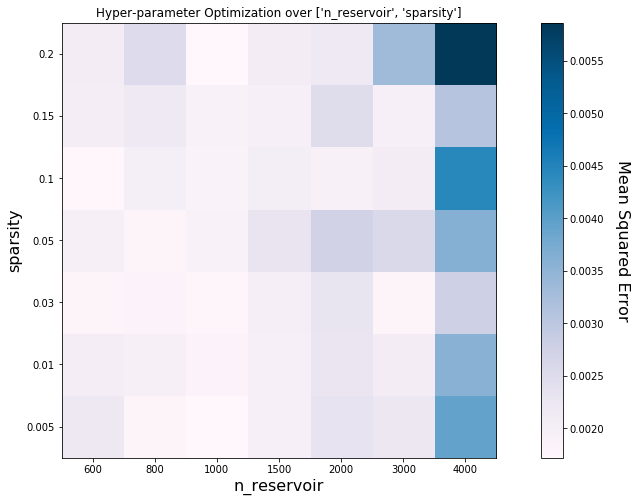

In [11]:
tic = time.perf_counter()
reservoir_set = [600, 800, 1000, 1500, 2000, 3000, 4000]
sparsity_set = [0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

sizexsparsity_loss = grid_optimizer(X_in.T,
                      params,
                      args=['n_reservoir', 'sparsity'],
                      xset=reservoir_set,
                      yset=sparsity_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [12]:
opt_size, opt_sparsity = optimal_values(sizexsparsity_loss, reservoir_set, sparsity_set)
params['n_reservoir'] = opt_size
params['sparsity'] = opt_sparsity
print(f'The optimal set is:\nreservoir size = {opt_size} \nsparsity = {opt_sparsity}')

The optimal set is:
reservoir size = 1000 
sparsity = 0.2


### 4. Demonstrate the Effect of Training Length

Once again, the algorithm is unstable when ``n_reservoir == trainlen``.

We should expect that MSE will decrease as training length increases.

Optimizing over ['trainlen']:
trainlen = 5000, MSE=0.0018386491572944786
trainlen = 5300, MSE=0.0019069697729459756
trainlen = 5600, MSE=0.001866236901380486
trainlen = 5900, MSE=0.0017214277619836955
trainlen = 6200, MSE=0.001725220958406532
trainlen = 6500, MSE=0.001900395721697164
trainlen = 6800, MSE=0.0020512535374481895
trainlen = 7100, MSE=0.0017717946200467764
trainlen = 7400, MSE=0.0015918714245173025
trainlen = 7700, MSE=0.0016950442242020388
trainlen = 8000, MSE=0.0017199270855005383
trainlen = 8300, MSE=0.0017183498409955988
trainlen = 8600, MSE=0.0015595101977237558
trainlen = 8900, MSE=0.0015743633035474672
trainlen = 9200, MSE=0.0017423626063390546
trainlen = 9500, MSE=0.0021080284095565537
trainlen = 9800, MSE=0.0018377728501147166
trainlen = 10100, MSE=0.0018877677459694278
trainlen = 10400, MSE=0.0019328950463762156
trainlen = 10700, MSE=0.002184761740965516
trainlen = 11000, MSE=0.0020750290606409596
trainlen = 11300, MSE=0.0015205890244702255
trainlen = 11600, MSE=0

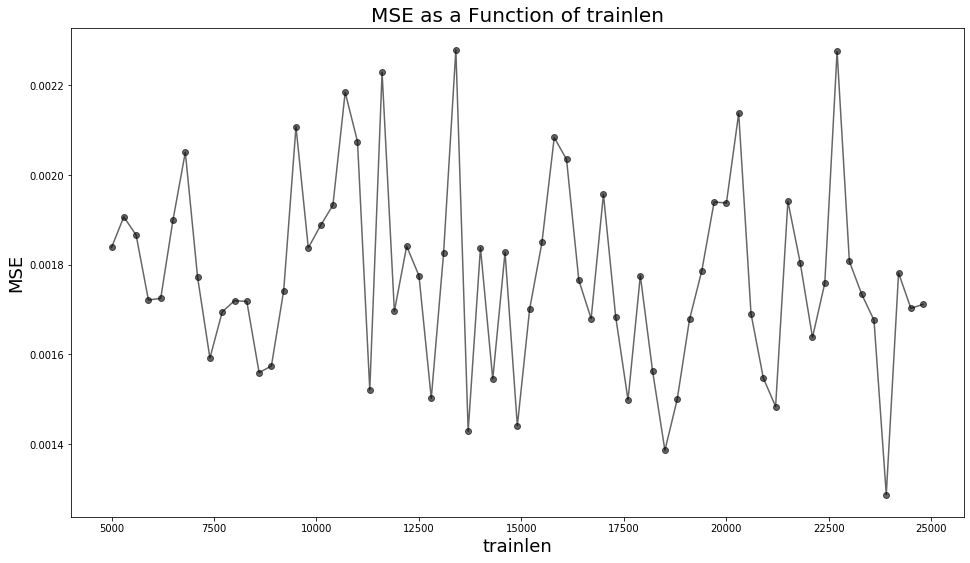

In [13]:
tic = time.perf_counter()
trainingLengths = np.arange(5000,25000,300)
trainlen_loss = grid_optimizer(X_in.T,
                      params,
                      args=['trainlen'],
                      xset=trainingLengths,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [14]:
minloss = np.min(trainlen_loss)
index_min = np.where(trainlen_loss == minloss)
l_opt = trainingLengths[index_min][0]
params['trainlen'] = l_opt

print(f"Training length with minimum error was: {l_opt}")

Training length with minimum error was: 23900


### 5. Optimized Demand Prediction


In [15]:
tic = time.perf_counter()

opt_pred = esn_prediction(X_in.T, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 42.23 seconds
This simulation took 0.70 minutes


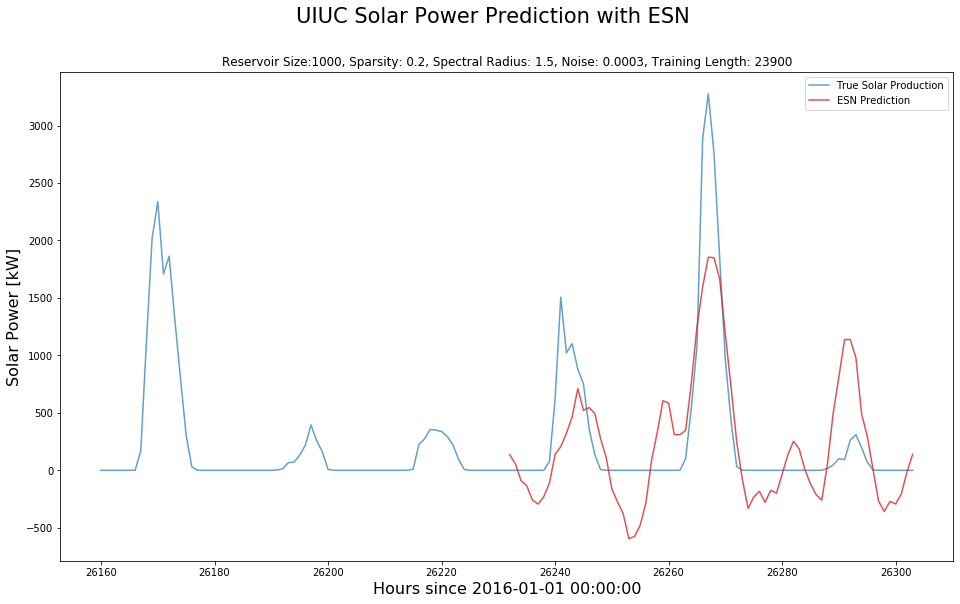

In [17]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Solar Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("Solar Power [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*solarpower_norm[-2*futureTotal:],'b',label="True Solar Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*opt_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()